# Import pacakages, data and functions

In [10]:
import itertools
import matlab.engine
import plotly.express as px
import plotly.graph_objs as go
import plotly

import drs
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import time
import pandas as pd
import glob
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump,load
import plotly.express as px

from zpyhelper.filesys import checkdir
from zpyhelper.MVPA.rdm import compute_rdm,lower_tri,upper_tri, compute_rdm_nomial, compute_rdm_identity
from zpyhelper.MVPA.preprocessors import scale_feature, average_odd_even_session,normalise_multivariate_noise, split_data, concat_data,extract_pc,average_flexi_session
from zpyhelper.MVPA.estimators import PatternCorrelation, MultipleRDMRegression, NeuralRDMStability

project_path = r'E:\pirate_fmri\Analysis'
sys.path.append(project_path)
from scripts.Exp1_fmri.multivariate.modelrdms import ModelRDM
from scripts.Exp1_fmri.multivariate.mvpa_runner import MVPARunner
from scripts.Exp1_fmri.multivariate.pirateOMutils import parallel_axes_cosine_sim, minmax_scale, generate_filters
from src.utils.composition_modelfit import multi_start_optimisation
from plotting_utils import plot_rdm_withlabel,gen_pval_annot,grouped_barscatter_withstats

import sklearn
from sklearn.manifold import MDS,TSNE 
import sklearn.manifold as manifold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor,MultiOutputClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score,r2_score

import scipy

import plotly.graph_objects as go
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

## set path to data and load data from ROI

In [4]:
study_scripts   = os.path.join(project_path,'scripts','Exp1_fmri')
studydata_dir  = os.path.join(project_path,'data','Exp1_fmri')
with open(os.path.join(study_scripts,'pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    cohort1ids = [x for x in pirate_defaults['participants']['cohort1ids'] if x in subid_list]
    cohort2ids = [x for x in pirate_defaults['participants']['cohort2ids'] if x in subid_list]
    fmribeh_dir = pirate_defaults['directory']['fmribehavior']
    fmridata_dir = pirate_defaults['directory']['fmri_data']
    nongeneralizers = pirate_defaults['participants']["nongeneralizerids"]
    generalizers    = pirate_defaults['participants']["generalizerids"]
print(len(subid_list))
print(len(cohort1ids))
print(len(cohort2ids))

fmridata_dir = os.path.join(project_path,'data','Exp1_fmri','fmri')
fmribeh_dir = os.path.join(fmridata_dir,'beh')

cohort_names_lists = dict(zip(["First Cohort","Second Cohort","Combined Cohort"],[cohort1ids,cohort2ids,subid_list]))
    

56
29
27


In [5]:
base_rois = ["HPC","vmPFC","V1","V2"]
anatrois =  [f"{x}_bilateral" for x in base_rois]
anatROIRSAdir = os.path.join(fmridata_dir,'ROIRSA','AALandHCPMMP1')
anatroi_data = load(os.path.join(anatROIRSAdir,"roi_data_4r.pkl"))
rois = anatrois
roi_data = anatroi_data
ROIRSAdir = anatROIRSAdir


<Axes: xlabel='tamapping_str', ylabel='count'>

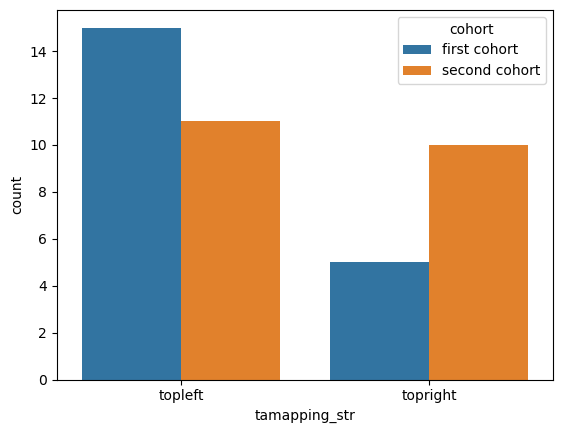

In [6]:
scanner_ave_perf = pd.read_csv(os.path.join(studydata_dir,"scanner_average_LLR_wmapping.csv"))
scanner_ave_perf["subid_cat"] = pd.Categorical(scanner_ave_perf.subid, categories=subid_list,ordered=True)
scanner_ave_perf = scanner_ave_perf.sort_values("subid_cat").reset_index(drop=True)
scanner_ave_perf.columns
sns.countplot(scanner_ave_perf[scanner_ave_perf.isgeneralizer=="generalizer"],x="tamapping_str",hue="cohort")

## get data ready

In [18]:
# get neural rdms for analysis

## initialize place holder for rdms and activity pattern matrix
stimsubgroups = ["training_nocenter","training_all","test","allstim_nocenter","allstim"]
sub_rdms, sub_patterns, sub_stimdfs = {}, {}, {}
for fname in stimsubgroups:
    sub_rdms[fname] = {}
    sub_patterns[fname] = {}
    sub_stimdfs[fname] = {}
    for roi in rois:
        sub_rdms[fname][roi] = []
        sub_patterns[fname][roi] = []
        sub_stimdfs[fname][roi] = []


## get neural rdms
for roi in rois:
    for subid,subdata in zip(subid_list,roi_data[roi]):
        
        preprocedX = deepcopy(subdata["preprocX"])
        stimdf = subdata["stimdf"].copy()
        
        navi_filter = stimdf.taskname.to_numpy() == "navigation"

        #average across sessions, so we get a 25*nvoxel matrix
        navi_X = np.mean(split_data(X      = preprocedX[navi_filter,:],
                                    groups = stimdf[navi_filter].copy().stim_session.to_numpy()),
                        axis=0)
        
        #filter out the df for just one session
        sub_dfall = stimdf[navi_filter&(stimdf.stim_session==0)].copy().reset_index(drop=True)
        sub_dfall['training_axsetstr'] = ["x" if axs==0 else "y" if axs==1 else "center" if np.logical_and(x==0,y==0) else np.nan for axs,x,y in sub_dfall[['training_axset','stim_x','stim_y']].to_numpy()]
        sub_dfall["stim_groupname"] = pd.Categorical(sub_dfall["stim_group"].map({0:"test",1:"training"}),categories=["training","test"],ordered=True)
        # make loc into integer
        sub_dfall["stim_x"] = sub_dfall["stim_x"]*2
        sub_dfall["stim_y"] = sub_dfall["stim_y"]*2
        sub_dfall["stim_xdist"] = sub_dfall["stim_xdist"]*2
        sub_dfall["stim_ydist"] = sub_dfall["stim_ydist"]*2
        sub_dfall["training_axlocTL"] = sub_dfall["training_axlocTL"]*2
        sub_dfall["training_axlocTR"] = sub_dfall["training_axlocTR"]*2

        #generate filters for various stimuli type
        subfilters = generate_filters(sub_dfall)

        for fname, curr_filt in subfilters.items():
            curr_df, curr_X = sub_dfall[curr_filt].copy().reset_index(drop=True), navi_X[curr_filt,:]
            ["training_nocenter","training_all","test","allstim_nocenter","allstim"]
            if fname == "training_nocenter":
                reordered_df = curr_df.sort_values(["training_axset","training_axlocTL"])
            elif fname == "training_all":
                curr_df['training_axsetstr_ordered'] = pd.Categorical(curr_df['training_axsetstr'],
                                                        categories=["x","center","y"])        
                reordered_df = curr_df.sort_values(["training_axsetstr_ordered","training_axlocTL"])
                reordered_df.drop(columns=['training_axsetstr_ordered'],inplace=True)
            elif fname == "test":
                reordered_df = curr_df.sort_values(["stim_x","stim_y"])
            elif fname == "allstim_nocenter":
                reordered_df = curr_df.sort_values(["stim_groupname","training_axset","training_axlocTL","stim_x","stim_y"])
            elif fname == "allstim":
                curr_df['training_axsetstr_ordered'] = pd.Categorical(curr_df['training_axsetstr'],
                                                        categories=["x","center","y"])        
                reordered_df = curr_df.sort_values(["stim_groupname","training_axsetstr_ordered","training_axlocTL","stim_x","stim_y"])
                reordered_df.drop(columns=['training_axsetstr_ordered'],inplace=True)
            
            reordered_X  = curr_X[reordered_df.index,:]

            subrdm = compute_rdm(reordered_X,metric="correlation")
            sub_rdms[fname][roi].append(subrdm)
            sub_patterns[fname][roi].append(reordered_X)
            sub_stimdfs[fname][roi].append(reordered_df)

## stimdf for navigation task stimuli
navi_stimdf = sub_dfall[['stim_id', 'stim_group', 'stim_session', 'stim_x', 'stim_y',
           'stim_xsign', 'stim_ysign', 'stim_xdist','stim_ydist',
           'training_axset','training_axsetstr','training_axlocTL','training_axlocTR',
           'stim_lrbux', 'stim_lrbuy', 'taskname']].copy()
stimsubgroup_filters = generate_filters(navi_stimdf)
navi_stimdf

,stim_id,stim_group,stim_session,stim_x,stim_y,stim_xsign,stim_ysign,stim_xdist,stim_ydist,training_axset,training_axsetstr,training_axlocTL,training_axlocTR,stim_lrbux,stim_lrbuy,taskname
0,0,0,0.0,-2.0,-2.0,-1.0,-1.0,2.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,navigation
1,1,0,0.0,-2.0,-1.0,-1.0,-1.0,2.0,1.0,NaN,NaN,NaN,NaN,2.0,3.0,navigation
2,2,1,0.0,-2.0,0.0,-1.0,0.0,2.0,0.0,0.0,x,-2.0,-2.0,2.0,0.0,navigation
3,3,0,0.0,-2.0,1.0,-1.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,2.0,1.0,navigation
4,4,0,0.0,-2.0,2.0,-1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,2.0,2.0,navigation
5,5,0,0.0,-1.0,-2.0,-1.0,-1.0,1.0,2.0,NaN,NaN,NaN,NaN,3.0,2.0,navigation
6,6,0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,NaN,NaN,NaN,NaN,3.0,3.0,navigation
7,7,1,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,0.0,x,-1.0,-1.0,3.0,0.0,navigation
8,8,0,0.0,-1.0,1.0,-1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,3.0,1.0,navigation
9,9,0,0.0,-1.0,2.0,-1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,3.0,2.0,navigation


# MDS

In [22]:
eng = matlab.engine.start_matlab()

In [78]:
## plotly interactive 3D plots
fname = 'allstim'
curr_filt = stimsubgroup_filters[fname]
AllstimMDS2D = {}
AllstimMDS3D = {}
for cohortname,clist in cohort_names_lists.items():
    AllstimMDS2D[cohortname] = {}
    AllstimMDS3D[cohortname] = {}
    for roi in rois:
        AllstimMDS2D[cohortname][roi] = {}
        AllstimMDS3D[cohortname][roi] = {}
        Grdm_scaled_mean = np.mean([minmax_scale(m,newmax=1,newmin=0) for m,subid in zip(sub_rdms[fname][roi],subid_list) if subid in generalizers and subid in clist],axis=0)
        NGrdm_scaled_mean = np.mean([minmax_scale(m,newmax=1,newmin=0) for m,subid in zip(sub_rdms[fname][roi],subid_list) if subid not in generalizers and subid in clist],axis=0)
        
        # Grdm_scaled_mean = np.mean([m for m,subid in zip(sub_rdms[fname][roi],subid_list) if subid in generalizers],axis=0)
        # NGrdm_scaled_mean = np.mean([m for m,subid in zip(sub_rdms[fname][roi],subid_list) if subid not in generalizers],axis=0)

        for subgroup, sgrdm in zip(["Generalizers","nonGeneralizers"],[Grdm_scaled_mean,NGrdm_scaled_mean]):
            outputdir = os.path.join(ROIRSAdir,"MDS",f"{fname}_TLmapping")
            checkdir(outputdir)
            # take the first participants df as the df, because everyone is ordered in the same way
            MDS_res2 = sub_stimdfs[fname][roi][0].drop(columns=['stim_color', 'stim_shape','resp_x', 'resp_y','resp_xsign', 'resp_ysign', 'resp_xdist', 'resp_ydist'],inplace=False)
            MDS_res2[["MDSax1","MDSax2"]] = np.array(eng.cmdscale(sgrdm,2))
        
            MDS_res3 = sub_stimdfs[fname][roi][0].drop(columns=['stim_color', 'stim_shape','resp_x', 'resp_y','resp_xsign', 'resp_ysign', 'resp_xdist', 'resp_ydist'],inplace=False)
            MDS_res3[["MDSax1","MDSax2","MDSax3"]] = np.array(eng.cmdscale(sgrdm,3))
        
            AllstimMDS2D[cohortname][roi][subgroup] = (sgrdm,MDS_res2)
            AllstimMDS3D[cohortname][roi][subgroup] = (sgrdm,MDS_res3)

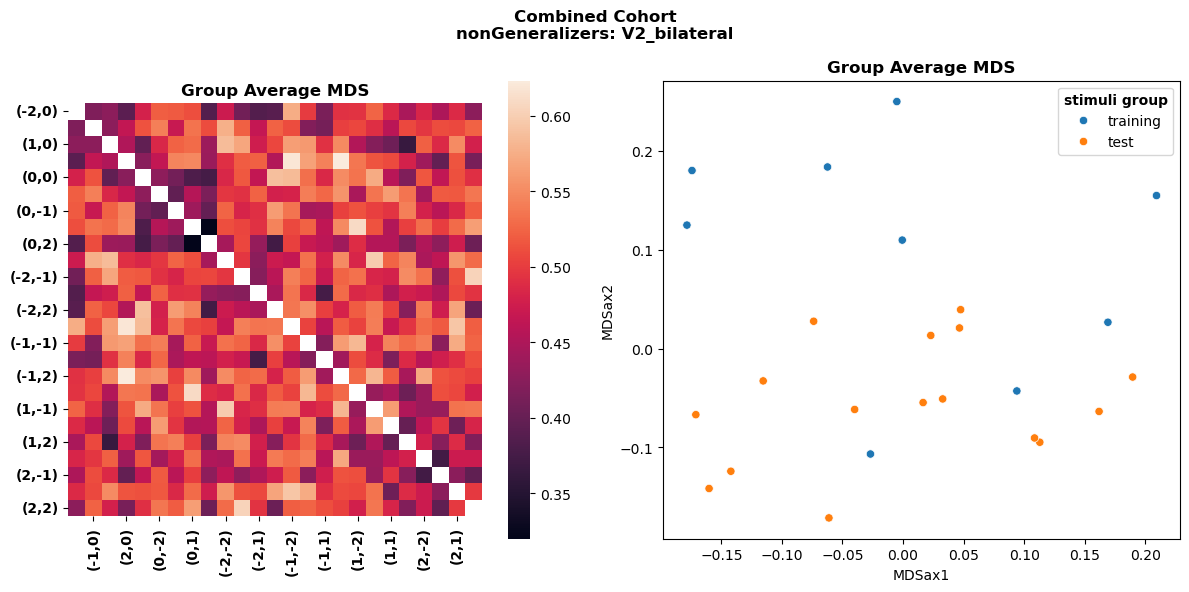

In [ ]:
for cohortname,clist in cohort_names_lists.items():
    for j,roi in enumerate(rois):
        for k,(subgroup,(sgrdm,MDS_res)) in enumerate(AllstimMDS2D[cohortname][roi].items()):
            pltrdm = deepcopy(sgrdm)
            np.fill_diagonal(pltrdm,np.nan)
            
            plt.close()
            figmds,axesmds = plt.subplots(1,2,figsize=(12,6))
            sns.heatmap(pltrdm,square=True,ax=axesmds[0])#cmap="cividis", 
            stimnames = ["(%d,%d)" % (x,y) for x,y in MDS_res[["stim_x","stim_y"]].to_numpy()]
            xticks = (np.arange(12))*2+1
            yticks = np.arange(13)*2
            axesmds[0].set_xticks(ticks=xticks+0.5)
            axesmds[0].set_xticklabels(labels=np.array(stimnames)[xticks],rotation=90,fontweight="bold")
            axesmds[0].set_yticks(ticks=yticks+0.5)
            axesmds[0].set_yticklabels(labels=np.array(stimnames)[yticks],rotation=0,fontweight="bold")
            axesmds[0].set_title(f"Group Average MDS",fontweight="bold")

            sns.scatterplot(MDS_res,x="MDSax1",y="MDSax2",hue="stim_groupname",ax=axesmds[1])
            axesmds[1].legend(title="stimuli group",title_fontproperties ={"weight":"bold","size":"medium"})
            axesmds[1].set_title(f"Group Average MDS",fontweight="bold")
            
            figmds.suptitle(f"{cohortname}\n{subgroup}: {roi}",fontweight="bold",fontsize="large")
            figmds.tight_layout()

            opdir = os.path.join(ROIRSAdir,"classicalMDS",fname)
            checkdir(opdir)
            figmds.savefig(os.path.join(opdir,f"twoD_{cohortname}_{subgroup}_{roi}.png"))
            

In [ ]:
for cohortname,clist in cohort_names_lists.items():
    for j,roi in enumerate(rois):
        for k,(subgroup,(sgrdm,MDS_res)) in enumerate(AllstimMDS3D[cohortname][roi].items()):
            pltrdm = deepcopy(sgrdm)
            np.fill_diagonal(pltrdm,np.nan)
            
            figmds = px.scatter_3d(MDS_res, x="MDSax1", y="MDSax2", x="MDSax1")

            sns.scatterplot(MDS_res,x="MDSax1",y="MDSax2",hue="stim_groupname",ax=axesmds[1])
            axesmds[1].legend(title="stimuli group",title_fontproperties ={"weight":"bold","size":"medium"})
            axesmds[1].set_title(f"Group Average MDS",fontweight="bold")
            
            figmds.suptitle(f"{cohortname}\n{subgroup}: {roi}",fontweight="bold",fontsize="large")
            figmds.tight_layout()

            opdir = os.path.join(ROIRSAdir,"classicalMDS",fname)
            checkdir(opdir)
            figmds.savefig(os.path.join(opdir,f"threeD_{cohortname}_{subgroup}_{roi}.html"))
            

# Decoding

In [ ]:
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut,LeavePGroupsOut
from sklearn.model_selection import GridSearchCV
from zpyhelper.MVPA.preprocessors import extract_pc,average_flexi_session
def classifier_cv(X,targets,split_groups,baseclf=LinearSVC,baseclf_kwargs={},return_splits=False,
                  return_decoder=False):
    logo = LeaveOneGroupOut()
    fit_acc,pred_acc = [],[]
    decoders = []
    for i, (fit_idx, eval_idx) in enumerate(logo.split(X,targets,groups=split_groups)):
        if np.ndim(targets)>1:
            
            clf = MultiOutputClassifier(baseclf(**baseclf_kwargs))
            clf.fit(X[fit_idx,:],targets[fit_idx,:])
            fit_acc.append(clf.score(X[fit_idx,:],targets[fit_idx,:]))
            pred_acc.append(clf.score(X[eval_idx,:],targets[eval_idx,:]))
        else:
            
            clf = baseclf(**baseclf_kwargs)
            clf.fit(X[fit_idx,:],targets[fit_idx])
            
            fit_acc.append(clf.score(X[fit_idx,:],targets[fit_idx]))
            pred_acc.append(clf.score(X[eval_idx,:],targets[eval_idx]))
        decoders.append(clf)
        
    if return_splits:
        if return_decoder:
            return fit_acc,pred_acc,decoders
        else:
            return fit_acc,pred_acc
    else:
        if return_decoder:
            return np.mean(fit_acc),np.mean(pred_acc),decoders
        else:
            return np.mean(fit_acc),np.mean(pred_acc)

def classifier_gridsearchcv_cv(X,targets,split_groups,
                               gridsearcg_paramgrid,gridsearch_groups,
                               baseclf=LinearSVC,baseclf_kwargs={},return_splits=False,
                               return_decoder=False):
    logo = LeaveOneGroupOut()
    fit_acc,pred_acc = [],[]
    decoders = []
    for i, (fit_idx, eval_idx) in enumerate(logo.split(X,targets,groups=split_groups)):
        
        clf = GridSearchCV(baseclf(**baseclf_kwargs),
                            param_grid=gridsearcg_paramgrid,
                            cv=LeaveOneGroupOut())
        clf.fit(X[fit_idx,:],targets[fit_idx],groups=gridsearch_groups[fit_idx])

        fit_acc.append(clf.score(X[fit_idx,:],targets[fit_idx]))
        pred_acc.append(clf.score(X[eval_idx,:],targets[eval_idx]))
        decoders.append(clf)
        
    if return_splits:
        if return_decoder:
            return fit_acc,pred_acc,decoders
        else:
            return fit_acc,pred_acc
    else:
        if return_decoder:
            return np.mean(fit_acc),np.mean(pred_acc),decoders
        else:
            return np.mean(fit_acc),np.mean(pred_acc)
        
from zpyhelper.MVPA.preprocessors import extract_pc,average_flexi_session